# Quads design (3dp pla + blue shims) for angular momentum design with single target region


## Imports

NOTE: Please download data associated to this repository from https://doi.org/10.5281/zenodo.12823471


In [1]:
from difflexmm.utils import save_data, load_data
from difflexmm.geometry import QuadGeometry
from difflexmm.plotting import generate_animation, generate_frames, plot_geometry
from problems.quads_spin import ForwardProblem, OptimizationProblem, ForwardInput
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
from pathlib import Path

import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)  # enable float64 type
# config.update("jax_log_compiles", 1)

plt.style.use(["science", "grid"])
%matplotlib widget


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Plotting functions


In [2]:
from matplotlib.collections import LineCollection


def plot_target_motion(optimization: OptimizationProblem, figsize=(3, 3), fontsize=16, linewidth=2, cmap=cm.Oranges, line_timepoints=None, arrow_timepoints=None, color=None, annotate=False):
    if not optimization.is_setup:
        optimization.setup_objective()

    fig, axes = plt.subplots(figsize=figsize, constrained_layout=True)
    axes.set_position([0.25, 0.25, 0.74, 0.74])
    # Color line based on time
    points = optimization.forward_problem.solution_data.fields[:,
                                                               0, optimization.target_blocks, :2].mean(axis=1)
    if line_timepoints is not None:
        points = points[line_timepoints]
    else:
        line_timepoints = jnp.arange(len(points))
    # Create line segments
    segments = jnp.concatenate([points[:-1, None], points[1:, None]], axis=1)
    lines = LineCollection(
        segments,
        array=optimization.forward_problem.solution_data.timepoints[line_timepoints[:len(
            segments)]],
        cmap=cmap,
        norm=plt.Normalize(
            0, optimization.forward_problem.solution_data.timepoints[-1]),
        linewidths=linewidth,
        zorder=10,
        antialiased=True,
    )
    if color is not None:
        lines = LineCollection(
            [points],
            colors=color,
            linewidths=linewidth,
            zorder=10,
            antialiased=True,
        )

    axes.add_collection(lines)
    if arrow_timepoints is not None:
        axes.scatter(
            optimization.forward_problem.solution_data.fields[arrow_timepoints, 0][:, optimization.target_blocks, 0].mean(
                axis=1),
            optimization.forward_problem.solution_data.fields[arrow_timepoints, 0][:, optimization.target_blocks, 1].mean(
                axis=1),
            s=60,
            color=cmap(1.),
            zorder=20,
            edgecolor="white",
            linewidth=1.,
        )
        axes.quiver(
            optimization.forward_problem.solution_data.fields[arrow_timepoints, 0][:, optimization.target_blocks, 0].mean(
                axis=1),
            optimization.forward_problem.solution_data.fields[arrow_timepoints, 0][:, optimization.target_blocks, 1].mean(
                axis=1),
            optimization.forward_problem.solution_data.fields[arrow_timepoints, 1][:, optimization.target_blocks, 0].mean(
                axis=1),
            optimization.forward_problem.solution_data.fields[arrow_timepoints, 1][:, optimization.target_blocks, 1].mean(
                axis=1),
            scale=300,
            scale_units="xy",
            width=0.02,
            color=cmap(1.),
            zorder=10,
            edgecolor="white",
            linewidth=1.,
        )
        # Annotate the arrows
        if annotate:
            for i, t in enumerate(arrow_timepoints):
                axes.text(
                    optimization.forward_problem.solution_data.fields[t, 0, optimization.target_blocks, 0].mean(
                    ),
                    optimization.forward_problem.solution_data.fields[t, 0, optimization.target_blocks, 1].mean(
                    ),
                    f"${i}$",
                    fontsize=fontsize,
                    zorder=20,
                )

    axes.axis("equal")
    x_ext = axes.get_xlim()[1] - axes.get_xlim()[0]
    y_ext = axes.get_ylim()[1] - axes.get_ylim()[0]
    axes.set(xlim=(axes.get_xlim()[0]-0.1*x_ext, axes.get_xlim()[1]+0.1*x_ext),
             ylim=(axes.get_ylim()[0]-0.1*y_ext, axes.get_ylim()[1]+0.1*y_ext))
    axes.set_xlabel(r"$x$ [mm]", fontsize=fontsize)
    axes.set_ylabel(r"$y$ [mm]", fontsize=fontsize)
    axes.grid(False)
    axes.axhline(y=0, color="black", lw=1, zorder=0)
    axes.axvline(x=0, color="black", lw=1, zorder=0)
    for spine in axes.spines.values():
        spine.set_linewidth(1)
    axes.tick_params(labelsize=fontsize-2)

    return fig, axes

## Optimal design and response


In [3]:
# NOTE: Units are mm, N, s

# Geometrical params
n1_blocks = 24
n2_blocks = 16
spacing = 15.  # 1.0  # 15 mm
hinge_length = 0.15*spacing  # Same as bond length
initial_angle = 25*jnp.pi/180
horizontal_shifts, vertical_shifts = QuadGeometry(n1_blocks, n2_blocks, spacing=spacing, bond_length=hinge_length).get_design_from_rotated_square(
    angle=initial_angle,
)  # Initial design

# Mechanical params
k_stretch = 120.  # stretching stiffness 120. N/mm
k_shear = 1.19  # shearing stiffness 1.19 N/mm
k_rot = 1.50  # rotational stiffness 1.50 Nmm
density = 6.18e-9  # Mg/mm^2
# NOTE: Damping is assumed to be the same for all blocks as it is small enough that the inertia change during optimization is negligible.
# The reference is taken to be zero angle rotated square geometry.
# 0.36125, 0.02175026 = mass and inertia of a single square of zero angle and unitary spacing and density and 0.15 bond length.
damping = 0.0186 * jnp.array([
    2 * (0.36125 * density * spacing**2 * k_shear)**0.5,
    2 * (0.36125 * density * spacing**2 * k_shear)**0.5,
    2 * (0.02175026 * density * spacing**4 * k_rot)**0.5
]) * jnp.ones((n1_blocks*n2_blocks, 3))

# Dynamic loading
amplitude = 0.5 * spacing
loading_rate = 30.  # Hz loading frequency for dynamic input

# Forward problem
problem = ForwardProblem(
    # Geometrical params
    n1_blocks=n1_blocks,
    n2_blocks=n2_blocks,
    spacing=spacing,
    bond_length=hinge_length,
    # Mechanical params
    k_stretch=k_stretch,
    k_shear=k_shear,
    k_rot=k_rot,
    density=density,
    damping=damping,
    use_contact=True,
    k_contact=k_rot,
    min_angle=-15*jnp.pi/180,
    cutoff_angle=-10*jnp.pi/180,
    # Dynamic loading
    amplitude=amplitude,
    loading_rate=loading_rate,
    input_delay=0.1*loading_rate**-1,
    n_excited_blocks=2,
    loaded_side="bottom",
    input_shift=4,
    # Analysis params
    simulation_time=5*loading_rate**-1,  # s
    n_timepoints=5*50, # 5 cycles
    # Solver tolerances
    atol=1e-4,
    # Problem name (folder name)
    name="quads_spin_3dp_pla_shims",
)

# Forward input
forward_input = ForwardInput(
    horizontal_shifts=horizontal_shifts,
    vertical_shifts=vertical_shifts,
)
# Optimization problem
target_size = (2, 2)
target_shift = (-3, 3)
optimization = OptimizationProblem(
    forward_problem=problem,
    forward_input=forward_input,
    target_size=target_size,
    target_shift=target_shift,
    spin_center="center",
    goal="min",
    name=problem.name,
)

problem_filename = f"quads{'_linearized_strains' if problem.linearized_strains else ''}_{problem.n1_blocks}x{problem.n2_blocks}_loaded_{problem.loaded_side}_excited_blocks_{problem.n_excited_blocks}_amplitude_{problem.amplitude:.2f}_loading_rate_{problem.loading_rate:.2f}_input_shift_{problem.input_shift}_initial_angle_{initial_angle*180/jnp.pi:.1f}"
optimization_filename = f"opt_{optimization.goal}_with_angle_30_and_length_3_constraints_{problem_filename}_target_size_{optimization.target_size[0]}x{optimization.target_size[1]}_target_shift_{optimization.target_shift[0]}x{optimization.target_shift[1]}_spin_center_{optimization.spin_center}"


### Import most recent optimization object


In [4]:
# NOTE: Data can be downloaded from https://doi.org/10.5281/zenodo.12823471

optimization = OptimizationProblem.from_dict(
    load_data(
        f"../data/{optimization.name}/{optimization_filename}.pkl",
    )
)


### Run optimization


In [ ]:
# optimization.run_optimization_nlopt(
#     initial_guess=(forward_input.horizontal_shifts, forward_input.vertical_shifts),
#     # initial_guess=optimization.design_values[-1],
#     n_iterations=60,
#     min_block_angle=30*jnp.pi/180,
#     min_void_angle=0*jnp.pi/180,
#     min_edge_length=3.,  # mm
#     max_time=4*60*60,  # 8 hour
#     # lower_bound=-0.22*optimization.forward_problem.spacing,
#     # upper_bound=0.22*optimization.forward_problem.spacing,
# )

# save_data(
#     f"../data/{optimization.name}/{optimization_filename}.pkl",
#     optimization.to_dict()  # Optimization problem
# )


### Plots

In [4]:
# NOTE: Data can be downloaded from https://doi.org/10.5281/zenodo.12823471

optimization = OptimizationProblem.from_dict(
    load_data(
        f"../data/{optimization.name}/{optimization_filename}.pkl",
    )
)

### Plot objective function

In [ ]:
fig, axes = plt.subplots(nrows=3, figsize=(10, 7), sharex=True)
axes[0].set(ylabel="Objective")
axes[0].plot(optimization.objective_values, lw=3, color="#2980b9")
axes[1].set(ylabel="Angle constraints violation")
axes[1].plot(optimization.constraints_violation["angles"], lw=3, color="#c0392b")
axes[1].axhline(y=0, color="black")
axes[2].set(xlabel="Iteration", ylabel="Edge length constraints violation")
axes[2].plot(optimization.constraints_violation["edge_lengths"], lw=3, color="#c0392b")
axes[2].axhline(y=0, color="black")
fig.tight_layout()

path = Path(
    f"../out/{optimization.name}/{optimization_filename}/objective_iterations.png")
path.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist
fig.savefig(str(path), dpi=300)


### Optimized design

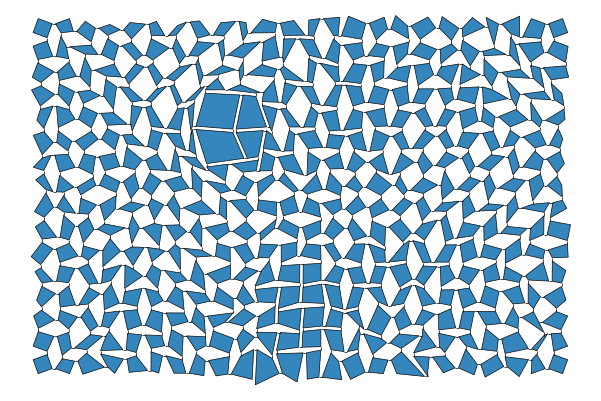

In [5]:
problem = optimization.forward_problem
problem.setup()
design_values = optimization.design_values[-1]

xlim, ylim = problem.geometry.get_xy_limits(
    *design_values) + 0.5*problem.geometry.spacing * jnp.array([-1, 1])
fig, ax = plot_geometry(
    block_centroids=problem.geometry.block_centroids(*design_values),
    centroid_node_vectors=problem.geometry.centroid_node_vectors(
        *design_values),
    bond_connectivity=problem.geometry.bond_connectivity(),
    xlim=xlim,
    ylim=ylim,
    figsize=(6, 6*16/24),
)
ax.axis("off")

path = Path(
    f"../out/{optimization.name}/{optimization_filename}/best_design.png")
# Make sure parents directories exist
path.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(str(path), dpi=300)

### Target region trajectory

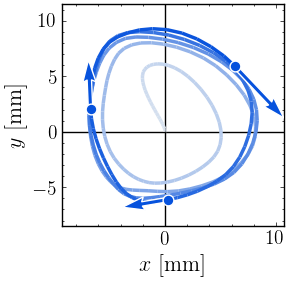

In [6]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    "pareto",
    ("#ecf0f1", "#0652DD") if optimization.goal == "min" else ("#ecf0f1", "#009432"),
)
arrow_timepoints = jnp.array([-33-1, -1-17, -1])
fig, axes = plot_target_motion(
    optimization,
    fontsize=16,
    linewidth=2.5,
    figsize=(3, 3),
    cmap=cmap,
    arrow_timepoints=arrow_timepoints,
)
path = Path(
    f"../out/{optimization.name}/{optimization_filename}/target_motion.png")
# Make sure parents directories exist
path.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(str(path), dpi=300)

In [ ]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    "pareto",
    ("#ecf0f1", "#0652DD") if optimization.goal == "min" else ("#ecf0f1", "#009432"),
)
arrow_timepoints = jnp.array([-33-1, -1-17, -1])
fig, axes = plot_target_motion(
    optimization,
    fontsize=16,
    linewidth=2.5,
    figsize=(3, 3),
    cmap=cmap,
    arrow_timepoints=arrow_timepoints,
    line_timepoints=jnp.arange(-52, -1),
    color=cmap(1.),
    annotate=True,
)
# Increase xylim by 10%
x_ext = axes.get_xlim()[1] - axes.get_xlim()[0]
y_ext = axes.get_ylim()[1] - axes.get_ylim()[0]
axes.set(xlim=(axes.get_xlim()[0]-0.1*x_ext, axes.get_xlim()[1]+0.1*x_ext),
         ylim=(axes.get_ylim()[0]-0.1*y_ext, axes.get_ylim()[1]+0.1*y_ext))
path = Path(
    f"../out/{optimization.name}/{optimization_filename}/target_motion_steady.svg")
# Make sure parents directories exist
path.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(str(path), dpi=300)

### Snapshots

In [7]:
arrow_timepoints = jnp.array([-33-1, -1-17, -1])

design_value = optimization.design_values[-1]
xlim, ylim = optimization.forward_problem.geometry.get_xy_limits(
    *design_value) + 3*optimization.forward_problem.geometry.spacing * jnp.array([[-1, 1], [-1, 1]])

generate_frames(
    optimization.forward_problem.solution_data,
    field="v",
    deformed=True,
    out_dir=f"../out/{optimization.name}/{optimization_filename}/snapshots",
    xlim=xlim,
    ylim=ylim,
    figsize=(6.5, 6*16/24),
    frame_range=arrow_timepoints,
    dpi=300,
    grid=False,
    axis=False,
    cmap="inferno",
    legend_label=r"Velocity [mm/s]",
)

### Animation

In [ ]:
design_value = optimization.design_values[-1]
xlim, ylim = optimization.forward_problem.geometry.get_xy_limits(*design_value) + 0.5*optimization.forward_problem.geometry.spacing * jnp.array([-1, 1])

generate_animation(
    optimization.forward_problem.solution_data,
    field="v",
    deformed=True,
    out_filename=f"../out/{optimization.name}/{optimization_filename}/animation",
    xlim=xlim,
    ylim=ylim,
    figsize=(6.5, 6*16/24),
    frame_range=jnp.arange(0, optimization.forward_problem.n_timepoints, 1),
    dpi=300,
    fps=30,
    grid=False,
    axis=False,
    cmap="inferno",
    legend_label=r"Velocity [mm/s]",
)
